In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt
from dateutil.parser import parse

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [11]:

results = session.query(Measurement.date, Measurement.prcp).order_by(Measurement.date.desc()).all()
latest = [result[0] for result in results[:1]][0]
latest = dt.datetime.strptime(latest, '%Y-%m-%d')

year_ago = latest - dt.timedelta(365)

results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > year_ago).order_by(Measurement.date.desc()).all()

d = [result[0] for result in results]
p = [result[1] for result in results]

df = pd.DataFrame(p, index=d, columns=['Precipitation'])
df.tail()

output = {}
for r in results:
    output[r[0]] = r[1]
    



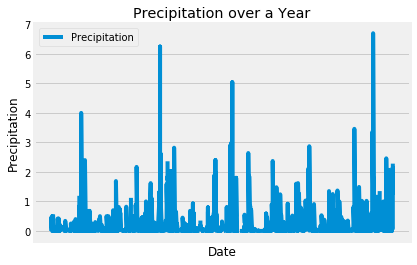

In [86]:
plt.plot(df, label='Precipitation')
plt.xticks([],[])
plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.title('Precipitation over a Year')
plt.legend()
plt.show()

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
i = ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']
v = [
    df['Precipitation'].count(),
    df['Precipitation'].mean(),
    df['Precipitation'].std(),
    df['Precipitation'].min(),
    df['Precipitation'].quantile(.25),
    df['Precipitation'].quantile(.5),
    df['Precipitation'].quantile(.75),
    df['Precipitation'].max()
]

summary = pd.DataFrame(v, index=i, columns=['Precipitation'])
summary

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# Design a query to show how many stations are available in this dataset?
session.query(Station.station).group_by(Station.station).count()

9

In [14]:
a = session.query(Measurement.station, func.count('*')).group_by(Measurement.station).filter(Measurement.date > year_ago).order_by((func.count('*')).desc()).all()
active = a[0][0]
a

[('USC00519397', 360),
 ('USC00519281', 351),
 ('USC00516128', 348),
 ('USC00513117', 342),
 ('USC00519523', 336),
 ('USC00514830', 304),
 ('USC00517948', 182)]

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == active).all()

[(56.0, 87.0, 74.55323054331865)]

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
observations = session.query(Measurement.tobs, func.count('*')).group_by(Measurement.tobs).filter(Measurement.date > year_ago).filter((Measurement.station == active)).all()
observations

[(60.0, 1),
 (61.0, 2),
 (62.0, 4),
 (63.0, 4),
 (64.0, 5),
 (65.0, 4),
 (66.0, 8),
 (67.0, 7),
 (68.0, 7),
 (69.0, 10),
 (70.0, 9),
 (71.0, 21),
 (72.0, 17),
 (73.0, 13),
 (74.0, 16),
 (75.0, 21),
 (76.0, 24),
 (77.0, 38),
 (78.0, 36),
 (79.0, 41),
 (80.0, 48),
 (81.0, 19),
 (82.0, 3),
 (83.0, 1),
 (87.0, 1)]

Text(0.5, 1.0, 'Frequency of Temperatures')

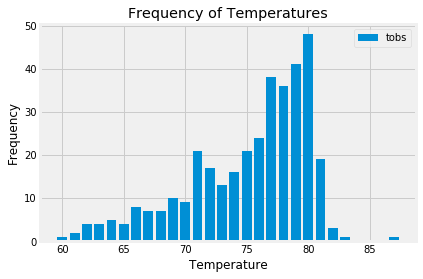

In [17]:
plt.bar([t[0] for t in observations], [t[1] for t in observations], label='tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend()
plt.title('Frequency of Temperatures')

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [22]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
calcs = calc_temps('2016-03-16', '2016-03-31')[0]
print(calcs)

(62.0, 70.77, 82.0)


Text(0.5, 1.0, 'Trip Average Temperature')

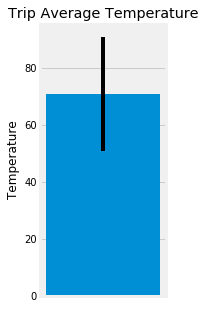

In [101]:
plt.figure(figsize=(2,5))
plt.bar(['0'], calcs[1], yerr=(calcs[2]-calcs[0]))
plt.xticks([],[])
plt.ylabel('Temperature')
plt.title('Trip Average Temperature')


In [103]:
session.query(Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp))\
.group_by(Measurement.station).filter(Measurement.date >= '2016-03-16').filter(Measurement.date <= '2016-03-31')\
.order_by(func.sum(Measurement.prcp).desc()).all()

[('USC00513117',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  46.349999999999945),
 ('USC00519281',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  13.229999999999995),
 ('USC00519523',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  10.43999999999998),
 ('USC00514830',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  8.999999999999988),
 ('USC00516128',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  8.189999999999989),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  2.3399999999999985),
 ('USC00517948', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0)]

## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


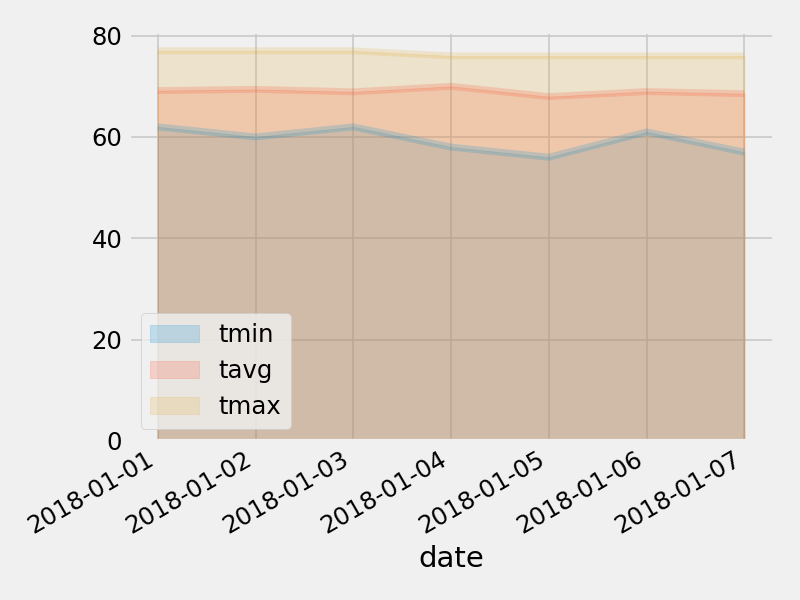

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
